# Make the entire thing into classes

Our target are: T=0.25,T=0.5,T=1.0 and Release


We are making into Release (high/low/medium) and Successful and unsuccessful.

1) This is available only for PLGAs. Others have not been used. 
“We deliberately focused only on PLGA-based LAIs and did not include non-PLGA based LAIs in the training set, to avoid the confounding effects of polymer properties and behaviors that differ substantially across polymer classes.”

What to do:
Yes, only apply the classification (Fast/Moderate/Slow, Success/Failure) to the PLGA-based entries if your goal is to:

Benchmark your SNN or classifier the same way the paper did

Avoid introducing uncontrolled variability

Later, when you're stable with PLGA predictions, you can build another model for non-PLGA or fine-tune your model using polymer type as a categorical feature. But for now — FILTER PLGA and stick to it.

2) “success and failure”.
Their Success and Failure is related to how overlapping it is with the ML Model. Like experimental V prediction.
Since the research paper has done experimental validation to consider Success or failure and we are NOT doing experimental validation should we remove that class entirely or should we consider changing our definition of Success and failure?

3) We cannot use Table 3. "These features are associated with fast or slow release behavior based on SHAP analysis"
"Some features have stronger influence on fast/slow release than others" 



First lets talk about the criteria to determine success or not.
Let us first determine what we mean by “success and failure”.
Their Success and Failure is related to how overlapping it is with the ML Model In our case, we are seeing if it is valid enough to be a PLAI or not.

For them, On seeing OLA-PLGA and SA-PLGA, 
SA-PLGA succeeded as it matched.
OLA-PLGA did not succeed because its release rate is not what is expected from the ML Model.
Isnt that like checking accuracy?
Yes, it is akin to checking accuracy, but with a focus on both short-term and long-term behavior. The success/failure evaluation is based on how well the predicted release profiles match the experimental release profiles , considering both immediate and delayed effects.  

For us, we should see if the planned or the given design is possible to be a
Drug polymer or not. 

So now we said OLA-PLGA is a failure because it didn’t match with what the research paper said.

Since the research paper has done experimental validation to consider Success or failure and we are NOT doing experimental validation should we remove that class entirely or should we consider changing our definition of Success and failure?


And coming to classes, first lets do based on Low/High release. They gave a table 3 to talk about it. Now i want to know what the fuck do they mean by low high medium values. If i know how they got it then i can 
Check and set range for “low” “high” “Medium” values.
Check, compare the values witht the range 
And then determine.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
df = pd.read_csv("Dataset_17_feat.csv")



Ok first lets determine cutoffs.

In [15]:
print(df["T=1.0"].describe())

count    3783.000000
mean        0.136479
std         0.125617
min         0.010000
25%         0.040000
50%         0.110000
75%         0.180000
max         0.720000
Name: T=1.0, dtype: float64


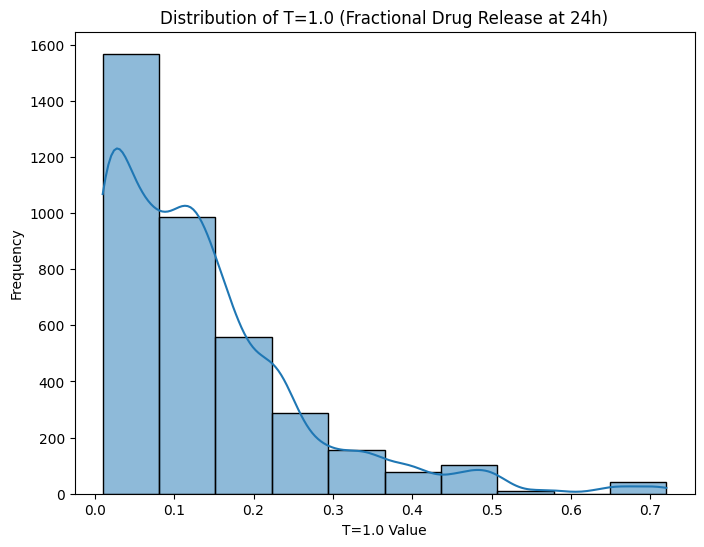

In [16]:
plt.figure(figsize=(8, 6))
sns.histplot(df["T=1.0"], bins=10, kde=True)
plt.title("Distribution of T=1.0 (Fractional Drug Release at 24h)")
plt.xlabel("T=1.0 Value")
plt.ylabel("Frequency")
plt.show()

We can take another approach.

We can use SA-PLGA(Fast) and OLA-PLGA(Slow) as benchmarks.

From the research paper and dataset:

SA-PLGA was designed as a fast-release formulation based on:
Low Drug_Mw (~138 g/mol)
Low Polymer_MW (~10 kDa)
Low DLC (~0.18)
Other favorable features like low Drug_TPSA, etc.

OLA-PLGA was designed as a slow-release formulation based on:
High Drug_Mw (~434 g/mol)
High Polymer_MW (~50 kDa)
Moderate DLC (~0.25)
Other unfavorable features like high Drug_TPSA, etc.
These two formulations were explicitly used in the paper as benchmarks for fast and slow release behavior.


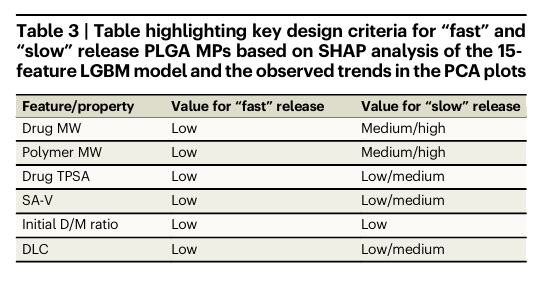



In [17]:
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import seaborn as sns

df = pd.read_csv("Dataset_17_feat.csv")

Our options to determine data into Fast, slow, moderate:
1)  Threshold-Based Classification Using T=1.0 (they adviced)
- fast slow moderate can be determind from percentiles.
- Plot histogram of T=1.0 – understand distribution.
-Pros:
Simple and interpretable,
Grounded in real-world data,
Matches paper's design criteria
Cons:
Only considers one feature,
May misclassify due to noise or outliers,

 T=1.0 provides the model with fractional drug release
 values after one day and could be considered a proxy for the initial
 drug release rate. For instance, low values of T=1.0 are likely to be
 indicative of sustained release profiles compared to LAIs with high
 fractional drug release at T=1.0. Thus, using T=1.0 as a proxy for
 initial drug release rates might inform the design attributes of new
 LAIs



2) Consider Drug MW, Polymer MW, Drug TPSA, SA-V, Initial D/M Ratio, DLC. 
- Percentiles:
Fast: Top 25% (above 75th percentile)
Moderate: Middle 50% (25th–75th percentile)
Slow: Bottom 25% (below 25th percentile)
- apply weights for each 
- Why these features?:

3) Set SA and OLA as benchmarks (use the Prediction.xlsx, Append it to the main dataset and use as benchmarks.)
- If closer to SA → Fast
- If closer to OLA → Slow
- If in between → Moderate
- Cosine similarity, threshold as idk lesse. Use T-sne for threshold determination.


4) consider the Time V Release and T=1.0,T=0.25,T = 0.5, compare their Slopes and decide accordingly
- Take SA, OLA as benchmarks

5) DBSCAN or KNN

### 1) using T=1.0


Distribution of Release Categories:
Release_Category_Percentile
Not PLGA    1869
Moderate     682
Slow         664
Fast         568
Name: count, dtype: int64


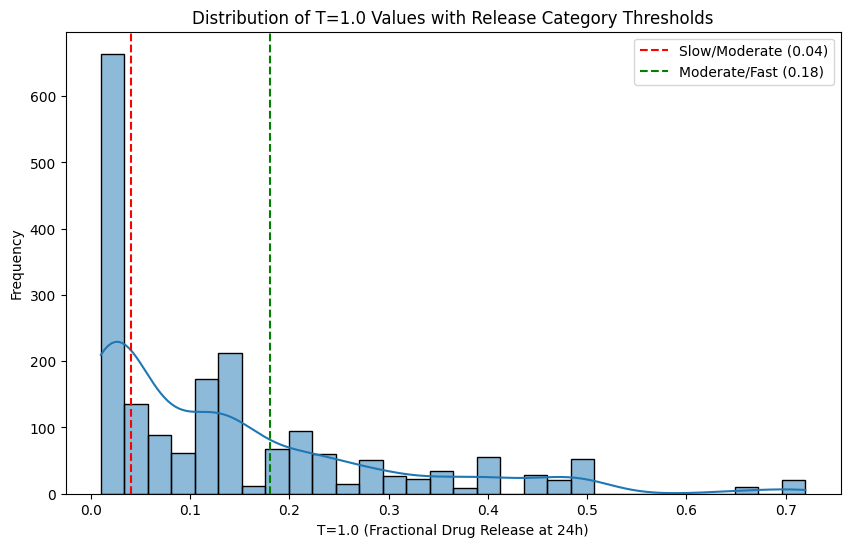

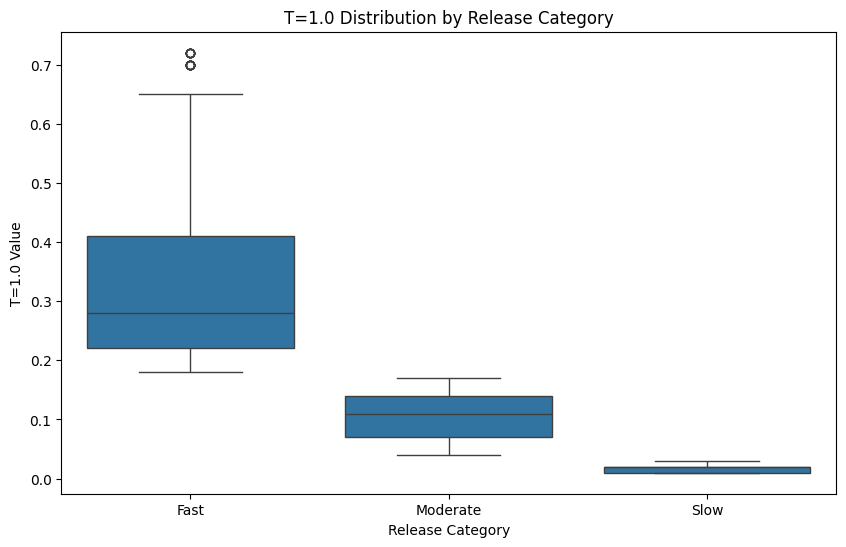

In [18]:
# Create a function to classify release rates based on T=1.0 percentiles
def classify_release_percentiles(row):
    """
    Classify drug release rates based on T=1.0 value percentiles:
    - Fast: ≥ 0.18 (top 25%)
    - Moderate: 0.04-0.18 (middle 50%)
    - Slow: < 0.04 (bottom 25%)
    """
    t1 = row['T=1.0']
    if pd.isna(t1) or t1 < 0 or t1 > 1:
        return 'Invalid'
    elif t1 >= 0.18:
        return 'Fast'
    elif t1 >= 0.04:
        return 'Moderate'
    else:
        return 'Slow'

# Create a mask for PLGA-based entries
is_plga = df['DP_Group'].str.contains('PLGA', case=False, na=False)

# Apply classification only to PLGA formulations
df['Release_Category_Percentile'] = 'Not PLGA'
df.loc[is_plga, 'Release_Category_Percentile'] = df[is_plga].apply(classify_release_percentiles, axis=1)

# Display counts of each category
print("Distribution of Release Categories:")
print(df['Release_Category_Percentile'].value_counts())

# Visualize distribution of T=1.0 values with category thresholds
plt.figure(figsize=(10, 6))
sns.histplot(df[is_plga]['T=1.0'], bins=30, kde=True)
plt.axvline(0.04, color='red', linestyle='--', label='Slow/Moderate (0.04)')
plt.axvline(0.18, color='green', linestyle='--', label='Moderate/Fast (0.18)')
plt.title('Distribution of T=1.0 Values with Release Category Thresholds')
plt.xlabel('T=1.0 (Fractional Drug Release at 24h)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Create a boxplot to compare T=1.0 distributions across categories
plt.figure(figsize=(10, 6))
sns.boxplot(x='Release_Category_Percentile', y='T=1.0', 
            data=df[df['Release_Category_Percentile'].isin(['Fast', 'Moderate', 'Slow'])])
plt.title('T=1.0 Distribution by Release Category')
plt.xlabel('Release Category')
plt.ylabel('T=1.0 Value')
plt.show()

In [19]:
def assign_category(row):
    # Only apply classification to PLGA-based formulations
    if not 'PLGA' in str(row['DP_Group']):
        return 'Not Applicable'
    
    # Get T=1.0 value for percentile-based classification
    t1 = row['T=1.0']
    if pd.isna(t1) or t1 < 0 or t1 > 1:
        return 'Invalid'
    
    # Primary classification based on T=1.0 thresholds (as in cell 15)
    if t1 >= 0.18:
        base_category = 'Fast'
    elif t1 >= 0.04:
        base_category = 'Moderate'
    else:
        base_category = 'Slow'
    
   
    
    # Add confidence level to category
    return f"{base_category}"

# Apply the function to create the new category column
df['category'] = df.apply(assign_category, axis=1)

# Display distribution of categories
print("Category Distribution:")
print(df['category'].value_counts())

Category Distribution:
category
Not Applicable    1869
Moderate           682
Slow               664
Fast               568
Name: count, dtype: int64


In [20]:
# Create a comprehensive release classification function
def classify_release_rate(row):
    """
    Classifies drug release profiles based on multiple criteria.
    Primary method: T=1.0 value thresholds
    Secondary factors: Polymer_MW, Drug_Mw, DLC
    
    Only applies to PLGA-based formulations.
    """
    # Skip non-PLGA formulations
    if 'PLGA' not in str(row['DP_Group']):
        return 'Not PLGA'
    
    # Get T=1.0 value for primary classification
    t1 = row['T=1.0']
    if pd.isna(t1) or t1 < 0 or t1 > 1:
        return 'Invalid'
    
    # Primary classification based on T=1.0 thresholds
    if t1 >= 0.18:
        category = 'Fast'
    elif t1 >= 0.04:
        category = 'Moderate'
    else:
        category = 'Slow'
    
    # Assess confidence level based on known correlations
    polymer_mw = row['Polymer_MW']
    drug_mw = row['Drug_Mw']
    dlc = row['DLC']
    
    # Initialize confidence as high
    confidence = 'High'
    
    # Check for conflicting indicators
    if category == 'Fast':
        if polymer_mw > 50000:  # Fast release but high MW polymer
            confidence = 'Medium'
        if drug_mw > 400:       # Fast release but high MW drug
            confidence = 'Medium'
        if dlc < 0.1:           # Fast release but low DLC
            confidence = 'Medium'
    elif category == 'Slow':
        if polymer_mw < 15000:  # Slow release but low MW polymer
            confidence = 'Medium'
        if drug_mw < 200:       # Slow release but low MW drug
            confidence = 'Medium'
        if dlc > 0.2:           # Slow release but high DLC
            confidence = 'Medium'
    
    return f"{category} "

# Apply the classification to df
df['Release_Classification'] = df.apply(classify_release_rate, axis=1)

# Display distribution of classifications
print("Release Classification Distribution:")
print(df['Release_Classification'].value_counts())

# Save the updated dataset to CSV
output_file = 'df_T1_classified.csv'
df.to_csv(output_file, index=False)
print(f"\nClassified dataset saved to {output_file}")

# Display sample of the classified data
print("\nSample classifications:")
display(df[['DP_Group', 'T=1.0', 'Release_Classification']].sample(5))

Release Classification Distribution:
Release_Classification
Not PLGA     1869
Moderate      682
Slow          664
Fast          568
Name: count, dtype: int64

Classified dataset saved to df_T1_classified.csv

Sample classifications:


,DP_Group,T=1.0,Release_Classification
978,LDC-PLGA,0.02,Slow
2587,PTX-PVL-co-PAVL,0.18,Not PLGA
699,IBP-PLGA,0.38,Fast
1038,LDC-PLGA,0.15,Moderate
3133,TAA-PLA-co-PALA,0.01,Not PLGA


### 2) 


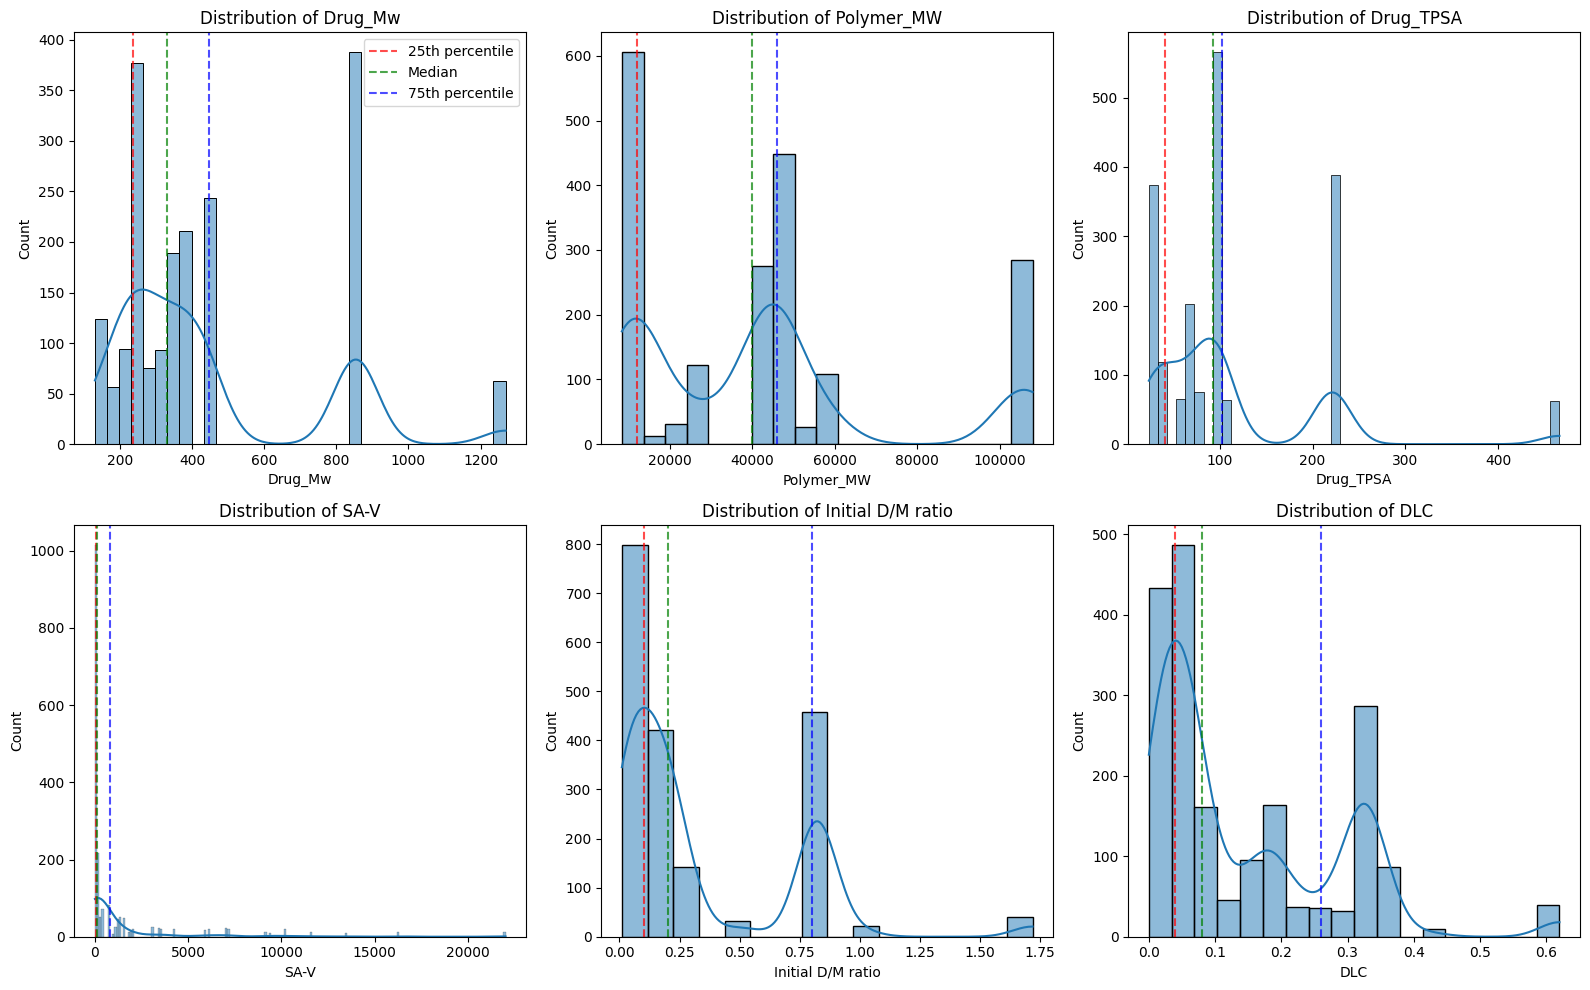

Descriptive Statistics for Key Features:



,count,mean,std,min,25%,50%,75%,max
Drug_Mw,1914.0,443.997638,280.883417,130.08,234.34,331.35,446.91,1269.47
Polymer_MW,1914.0,42127.115987,30974.588194,8300.00,12000.00,40000.00,46000.00,108000.00
Drug_TPSA,1914.0,112.307607,92.508122,23.47,40.46,93.06,102.28,466.34
SA-V,1914.0,1271.890026,3011.861270,2.89,63.76,115.38,789.47,22018.35
Initial D/M ratio,1914.0,0.340047,0.372987,0.01,0.10,0.20,0.80,1.72
DLC,1914.0,0.143955,0.138296,0.00,0.04,0.08,0.26,0.62



Correlation with Release Rate (T=1.0):


Polymer_MW           0.176136
Initial D/M ratio    0.138950
DLC                  0.063492
SA-V                 0.047698
Drug_TPSA           -0.267446
Drug_Mw             -0.341887
Name: T=1.0, dtype: float64

In [21]:
# Filter the dataset to include only PLGA-based formulations
plga_mask = df['DP_Group'].str.contains('PLGA', case=False, na=False)
df_plga = df[plga_mask]

# Generate descriptive statistics for key formulation parameters
key_features = ['Drug_Mw', 'Polymer_MW', 'Drug_TPSA', 'SA-V', 'Initial D/M ratio', 'DLC']
desc_stats = df_plga[key_features].describe().T

# Create a figure with subplots for histograms
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

# Plot histograms for each feature
for i, feature in enumerate(key_features):
    sns.histplot(df_plga[feature], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].axvline(desc_stats.loc[feature, '25%'], color='r', linestyle='--', alpha=0.7, label='25th percentile')
    axes[i].axvline(desc_stats.loc[feature, '50%'], color='g', linestyle='--', alpha=0.7, label='Median')
    axes[i].axvline(desc_stats.loc[feature, '75%'], color='b', linestyle='--', alpha=0.7, label='75th percentile')
    
    # Only show legend on first plot to avoid clutter
    if i == 0:
        axes[i].legend()

plt.tight_layout()
plt.show()

# Display the descriptive statistics
print("Descriptive Statistics for Key Features:\n")
display(desc_stats)

# Add correlation matrix of these features with T=1.0 (release rate)
print("\nCorrelation with Release Rate (T=1.0):")
corr_with_release = df_plga[key_features + ['T=1.0']].corr()['T=1.0'][:-1].sort_values(ascending=False)
display(corr_with_release)

"When the model confidence is low, the prediction requires experimental validation to confirm reliability.
In contrast, high-confidence predictions are more trustworthy and may not require immediate validation, especially if aligned with existing known behaviors."


“This prediction is likely to hold under real-world conditions, but experimental confirmation is still encouraged.”

🔴 Low confidence → "Experimental validation required"

🟡 Medium → "Consider validation before use"

🟢 High → "High trust, optional validation"



In [22]:
# # Create a comprehensive release classification function
# def classify_release_rate(row):
#     """
#     Classifies drug release profiles based on multiple criteria.
#     Primary method: T=1.0 value thresholds
#     Secondary factors: Polymer_MW,  Initial D/M ratio,  DLC,  SA-V,  Drug_TPSA,  Drug_Mw
#     Fast: Low Polymer_MW, Low Initial D/M ratio, Low DLC, Low SA-V, Low Drug_TPSA, Low Drug_Mw  
#     slow: High/Medium Polymer_MW, Low Initial D/M ratio,  Low Medium DLC, Low Medium SA-V, Low Medium Drug_TPSA, High/Medium Drug_Mw,
#     Only applies to PLGA-based formulations.
#     """
#     # Skip non-PLGA formulations
#     if 'PLGA' not in str(row['DP_Group']):
#         return 'Not PLGA'
    
#     # Get T=1.0 value for primary classification
#     t1 = row['T=1.0']
#     if pd.isna(t1) or t1 < 0 or t1 > 1:
#         return 'Invalid'
    
#     # Primary classification based on T=1.0 thresholds
#     if t1 >= 0.18:
#         category = 'Fast'
#     elif t1 >= 0.04:
#         category = 'Moderate'
#     else:
#         category = 'Slow'
    
#     # Assess confidence level based on known correlations
#     polymer_mw = row['Polymer_MW']
#     drug_mw = row['Drug_Mw']
#     dlc = row['DLC']
#     tpsa = row['Drug_TPSA']
#     sa_v = row['SA-V']
#     initial_dm_ratio = row['Initial D/M ratio']
#     ''''              count          mean           std      min       25%  \
#     Drug_Mw            1914.0    443.997638    280.883417   130.08    234.34   
#     Polymer_MW         1914.0  42127.115987  30974.588194  8300.00  12000.00   
#     Drug_TPSA          1914.0    112.307607     92.508122    23.47     40.46   
#     SA-V               1914.0   1271.890026   3011.861270     2.89     63.76   
#     Initial D/M ratio  1914.0      0.340047      0.372987     0.01      0.10   
#     DLC                1914.0      0.143955      0.138296     0.00      0.04   

#                             50%       75%        max  
#     Drug_Mw              331.35    446.91    1269.47  
#     Polymer_MW         40000.00  46000.00  108000.00  
#     Drug_TPSA             93.06    102.28     466.34  
#     SA-V                 115.38    789.47   22018.35  
#     Initial D/M ratio      0.20      0.80       1.72  
#     DLC                    0.08      0.26       0.62  '''
    
#     confidence = 0  # Score from 0 to 6 (max alignment)

#     if category == 'Fast':
#         if polymer_mw < 12000:
#             confidence += 1
#         if drug_mw < 235:
#             confidence += 1
#         if dlc < 0.1:
#             confidence += 1
#         if sa_v < 64:
#             confidence += 1
#         if tpsa < 40:
#             confidence += 1 
#         if initial_dm_ratio < 0.1:
#             confidence += 1

#     elif category == 'Moderate':
#         if 12000 <= polymer_mw <= 46000:
#             confidence += 1
#         if 235 <= drug_mw <= 450:
#             confidence += 1
#         if 0.1 <= dlc <= 0.2:
#             confidence += 1
#         if 64 <= sa_v <= 1000:
#             confidence += 1
#         if 40 <= tpsa <= 100:
#             confidence += 1
#         if 0.1 <= initial_dm_ratio <= 0.8:
#             confidence += 1

#     elif category == 'Slow':
#         if polymer_mw > 12000: # both medium and high right 
#             confidence += 1
#         if drug_mw < 200:
#             confidence += 1
#         if dlc > 0.2:
#             confidence += 1
#         if sa_v > 790:
#             confidence += 1  # Adding one more slow-indicator for balance
#         if tpsa < 60:
#             confidence += 1
#         if initial_dm_ratio < 0.2:
#             confidence += 1

#     # Convert score to label if you want
#     if confidence >= 5:
#         level = 'High'
#     elif confidence >= 3:
#         level = 'Medium'
#     else:
#         level = 'Low'

#     return f"{category} ({level} confidence)"

# # Apply the classification to df
# df['Release_Classification'] = df.apply(classify_release_rate, axis=1)

# # Display distribution of classifications
# print("Release Classification Distribution:")
# print(df['Release_Classification'].value_counts())

# # Save the updated dataset to CSV
# output_file = 'Conf_classified.csv'
# df.to_csv(output_file, index=False)
# print(f"\nClassified dataset saved to {output_file}")

# # Display sample of the classified data
# print("\nSample classifications:")
# display(df[['DP_Group', 'T=1.0', 'Release_Classification']].sample(5))

In [23]:
def classify_release_rate(row):
    """
    Classifies drug release profiles based on T=1.0 value thresholds.
    Returns only the category (Fast, Moderate, Slow).
    Confidence level is computed separately.
    
    Only applies to PLGA-based formulations.
    """
     # Skip non-PLGA formulations
    if 'PLGA' not in str(row['DP_Group']):
        return 'Not PLGA'
    
    # Get T=1.0 value for primary classification
    t1 = row['T=1.0']
    if pd.isna(t1) or t1 < 0 or t1 > 1:
        return 'Invalid'
    
    # Primary classification based on T=1.0 thresholds
    if t1 >= 0.18:
        return 'Fast'
    elif t1 >= 0.04:
        return 'Moderate'
    else:
        return 'Slow'

def calculate_confidence(row):
    """
    Calculates confidence level based on feature alignment with expected values
    for the assigned release category, using weighted scoring.
    
    Returns confidence level as 'High', 'Medium', or 'Low'.
    """
    # Skip non-PLGA formulations
    if 'PLGA' not in str(row['DP_Group']):
        return 'Not PLGA'
    
    # Get T=1.0 value for primary classification
    t1 = row['T=1.0']
    if pd.isna(t1) or t1 < 0 or t1 > 1:
        return 'Invalid'
    
    # Extract category and features
    category = row['Release_Classification']
    
    # Define weights for each feature
    weights = {
        'Drug_Mw': 33,
        'Drug_TPSA': 26,
        'Polymer_MW': 17, 
        'Initial D/M ratio': 13,
        'DLC': 6,
        'SA-V': 4.5
    }
    
    score = 0  # Weighted score
    max_score = sum(weights.values())  # Maximum possible score
    
    if category == 'Fast':
        if row['Polymer_MW'] < 12000:
            score += weights['Polymer_MW']
        if row['Drug_Mw'] < 235:
            score += weights['Drug_Mw']
        if row['DLC'] < 0.1:
            score += weights['DLC']
        if row['SA-V'] < 64:
            score += weights['SA-V']
        if row['Drug_TPSA'] < 40:
            score += weights['Drug_TPSA']
        if row['Initial D/M ratio'] < 0.1:
            score += weights['Initial D/M ratio']

    elif category == 'Moderate':
        if 12000 <= row['Polymer_MW'] <= 46000:
            score += weights['Polymer_MW']
        if 235 <= row['Drug_Mw'] <= 450:
            score += weights['Drug_Mw']
        if 0.1 <= row['DLC'] <= 0.2:
            score += weights['DLC']
        if 64 <= row['SA-V'] <= 1000:
            score += weights['SA-V']
        if 40 <= row['Drug_TPSA'] <= 100:
            score += weights['Drug_TPSA']
        if 0.1 <= row['Initial D/M ratio'] <= 0.8:
            score += weights['Initial D/M ratio']

    elif category == 'Slow':
        if row['Polymer_MW'] > 12000:
            score += weights['Polymer_MW']
        if row['Drug_Mw'] < 200:
            score += weights['Drug_Mw']
        if row['DLC'] > 0.2:
            score += weights['DLC']
        if row['SA-V'] > 790:
            score += weights['SA-V']
        if row['Drug_TPSA'] < 60:
            score += weights['Drug_TPSA']
        if row['Initial D/M ratio'] < 0.2:
            score += weights['Initial D/M ratio']

    # Calculate percentage score
    percentage = (score / max_score) * 100
    
    # Convert score to confidence level
    if percentage >= 70:
        return 'High'
    elif percentage >= 40:
        return 'Medium'
    else:
        return 'Low'

# Apply the classification to df
df['Release_Classification'] = df.apply(classify_release_rate, axis=1)

# Calculate confidence level as a separate column
df['Confidence_Level'] = df.apply(calculate_confidence, axis=1)

# Display distribution of classifications
print("Release Category Distribution:")
print(df['Release_Classification'].value_counts())

print("\nConfidence Level Distribution:")
print(df['Confidence_Level'].value_counts())


# Display sample of the classified data
print("\nSample classifications:")
display(df[['DP_Group', 'T=1.0', 'Release_Classification', 'Confidence_Level']].sample(5))
# Remove the Release_Category_Percentile and category columns
df = df.drop(['Release_Category_Percentile', 'category'], axis=1)

# Display updated column list
print("\nUpdated columns after removal:")
print(df.columns.tolist())

# Save the updated dataframe
output_file = 'Conf_classified_separate.csv'
df.to_csv(output_file, index=False)
print(f"\nCleaned dataset saved to {output_file}")

# Display the first few rows to confirm changes
display(df.head(3))

Release Category Distribution:
Release_Classification
Not PLGA    1869
Moderate     682
Slow         664
Fast         568
Name: count, dtype: int64

Confidence Level Distribution:
Confidence_Level
Not PLGA    1869
Low         1300
High         357
Medium       257
Name: count, dtype: int64

Sample classifications:


,DP_Group,T=1.0,Release_Classification,Confidence_Level
1603,PTX-PLGA,0.18,Fast,Low
2456,PTX-PVL-co-PAVL,0.06,Not PLGA,Not PLGA
3202,TAA-PLGA-co-PALA,0.01,Slow,Low
3313,TAA-PLGA-co-PAVL,0.02,Slow,Low
1836,PTX-PLGA-co-PALA,0.01,Slow,Low



Updated columns after removal:
['Experimental_index', 'DP_Group', 'LA/GA', 'Polymer_MW', 'CL Ratio', 'Drug_Tm', 'Drug_Pka', 'Initial D/M ratio', 'DLC', 'SA-V', 'SE', 'Drug_Mw', 'Drug_TPSA', 'Drug_NHA', 'Drug_LogP', 'Time', 'T=0.25', 'T=0.5', 'T=1.0', 'Release', 'Release_Classification', 'Confidence_Level']

Cleaned dataset saved to Conf_classified_separate.csv


,Experimental_index,DP_Group,LA/GA,Polymer_MW,CL Ratio,Drug_Tm,Drug_Pka,Initial D/M ratio,DLC,SA-V,...,Drug_TPSA,Drug_NHA,Drug_LogP,Time,T=0.25,T=0.5,T=1.0,Release,Release_Classification,Confidence_Level
0,80,5-FU-PLGA,1.0,104000.0,0.0,282.5,7.76,0.8,0.35,76.73,...,65.72,5.0,-0.8,0.00,0.09,0.19,0.35,0.00,Fast,Low
1,80,5-FU-PLGA,1.0,104000.0,0.0,282.5,7.76,0.8,0.35,76.73,...,65.72,5.0,-0.8,0.26,0.09,0.19,0.35,0.07,Fast,Low
2,80,5-FU-PLGA,1.0,104000.0,0.0,282.5,7.76,0.8,0.35,76.73,...,65.72,5.0,-0.8,1.06,0.09,0.19,0.35,0.40,Fast,Low
